In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv1D
import keras
import tensorflow as tf
def Percentage_Accuracy(y_true, y_pred):
    diff = keras.backend.abs(y_true-y_pred)
    correct = keras.backend.less(diff,0.05) 
    return keras.backend.mean(correct) 

Using TensorFlow backend.
A:\Anaconda\envs\ML_GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
A:\Anaconda\envs\ML_GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
A:\Anaconda\envs\ML_GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
A:\Anaconda\envs\ML_GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:526

In [2]:
keras.backend.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7389298693656916835,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4999020544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17515246441756572034
 physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [2]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&outputsize=full&apikey=EQ50I9Q6ZC3B43AX"
r = requests.get(url)
data = r.json()

In [3]:
df = pd.DataFrame.from_dict(list(data.values())[1],orient='index').reset_index()
# df = df.rename(columns={'index':'time' ,'1. open': 'open', '2. high':'high' , '3. low' : 'low', '4. close': 'close', '5. volume': 'volume'})
df = df.rename(columns={'index':'time' ,'1. open': 'open', '2. high':'high' , '3. low' : 'low', '4. close': 'close','5. adjusted close': 'adjclose', '6. volume': 'volume'})
split_size = int(len(df)-400)
df['time'] =pd.to_datetime(df.time)
df=df.sort_values(by='time').reset_index()
df

,index,time,open,high,low,close,adjclose,volume,7. dividend amount,8. split coefficient
0,5469,1999-11-01,98.5,98.81,96.37,96.75,60.047457645,9551800,0.0000,1.0
1,5468,1999-11-02,96.75,96.81,93.69,94.81,58.8434052643,11105400,0.0000,1.0
2,5467,1999-11-03,95.87,95.94,93.5,94.37,58.5703212192,10369100,0.0000,1.0
3,5466,1999-11-04,94.44,94.44,90.0,91.56,56.8263072038,16697600,0.0000,1.0
4,5465,1999-11-05,92.75,92.94,90.19,90.25,56.0132615241,13737600,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...
5465,4,2021-07-22,141.66,141.81,140.41,140.71,140.71,3314153,0.0000,1.0
5466,3,2021-07-23,140.96,141.7,140.33,141.34,141.34,4474157,0.0000,1.0
5467,2,2021-07-26,141.39,143.0,141.13,142.77,142.77,4246266,0.0000,1.0
5468,1,2021-07-27,142.53,143.64,141.6,142.75,142.75,3137027,0.0000,1.0


In [25]:
def set_maker(arr,sc):
    scaled_set = sc.transform(arr)# Creating a data structure with 60 time-steps and 1 output
    X = []
    y = []
    for i in range(30, len(arr)):
        X.append(scaled_set[i-30:i, 0])
        y.append(scaled_set[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    print(X.shape)
    print(y.shape)
    return X,y

In [26]:
# training_set_open = df.iloc[:int(len(df)*0.7), 1:2].values
# test_set_open = df.iloc[int(len(df)*0.7):, 1:2].values
# training_set_close = df.iloc[:int(len(df)*0.7), 4:5].values
# test_set_close = df.iloc[int(len(df)*0.7):, 4:5].values
training_set_open = df.iloc[:split_size, 1:2].values
test_set_open = df.iloc[split_size:, 1:2].values

training_set_high = df.iloc[:split_size, 2:3].values
test_set_high = df.iloc[split_size:, 2:3].values

training_set_low = df.iloc[:split_size, 3:4].values
test_set_low = df.iloc[split_size:, 3:4].values

training_set_close = df.iloc[:split_size, 4:5].values
test_set_close = df.iloc[split_size:, 4:5].values

training_set_vol = df.iloc[:split_size, 5:6].values
test_set_vol = df.iloc[split_size:, 5:6].values

In [27]:
sc_open = MinMaxScaler(feature_range = (-1, 1))
sc_close = MinMaxScaler(feature_range = (-1, 1))
sc_high = MinMaxScaler(feature_range = (-1, 1))
sc_vol = MinMaxScaler(feature_range = (-1, 1))
sc_low = MinMaxScaler(feature_range = (-1, 1))

sc_open.fit(training_set_open)
sc_high.fit(training_set_high)
sc_low.fit(training_set_low)
sc_vol.fit(training_set_vol)
sc_close.fit(training_set_close)

open_x,close_y = set_maker(training_set_open,sc_open)
high_x,close_y = set_maker(training_set_high,sc_high)
low_x,close_y = set_maker(training_set_low,sc_low)
vol_x,close_y = set_maker(training_set_vol,sc_vol)
close_x,close_y = set_maker(training_set_close,sc_close)

train_x = np.concatenate((open_x,high_x,low_x,vol_x,close_x),axis=2)

test_open_x,test_close_y = set_maker(test_set_open,sc_open)
test_high_x,test_close_y = set_maker(test_set_high,sc_high)
test_low_x,test_close_y = set_maker(test_set_low,sc_low)
test_vol_x,test_close_y = set_maker(test_set_vol,sc_close)
test_close_x,test_close_y = set_maker(test_set_close,sc_close)


(5040, 30, 1)
(5040,)
(5040, 30, 1)
(5040,)
(5040, 30, 1)
(5040,)
(5040, 30, 1)
(5040,)
(5040, 30, 1)
(5040,)
(370, 30, 1)
(370,)
(370, 30, 1)
(370,)
(370, 30, 1)
(370,)
(370, 30, 1)
(370,)
(370, 30, 1)
(370,)


In [38]:
input = tf.TensorArray(tf.float32, size = 0, dynamic_size=True, clear_after_read=False)
for i in range(train_x.shape[2]):
    input = input.write(i,keras.Input(shape = (train_x.shape[1],)))

In [30]:




model = Sequential()#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 30, return_sequences = True, ))
model.add(Conv1D(30,16,activation='relu'))
model.add(LSTM(units = 15, return_sequences = True))
model.add(Conv1D(15,8,activation='relu'))
model.add(LSTM(units = 7))
model.add(Dropout(0.2))# Adding the output layer
model.add(Dense(units = 1))

opt = keras.optimizers.Adamax()
lossfunction = keras.losses.mse
# Compiling the RNN
model.compile(optimizer = opt, loss = lossfunction, metrics=[Percentage_Accuracy],)

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 120, 120)          60480     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 60, 120)           878520    
_________________________________________________________________
lstm_8 (LSTM)                (None, 60, 60)            43440     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 30, 60)            111660    
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                10920     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total para

In [32]:
# Fitting the RNN to the Training set
with tf.device("/device:GPU:0"):
    model.fit(train_x, close_y, epochs = 30, batch_size = 60)

Epoch 1/30
4930/4930 [==============================] - 19s 4ms/step - loss: 0.0305 - Percentage_Accuracy: 0.2862
Epoch 2/30
4930/4930 [==============================] - 17s 4ms/step - loss: 0.0128 - Percentage_Accuracy: 0.3700
Epoch 3/30
4930/4930 [==============================] - 18s 4ms/step - loss: 0.0101 - Percentage_Accuracy: 0.4063
Epoch 4/30
4930/4930 [==============================] - 19s 4ms/step - loss: 0.0091 - Percentage_Accuracy: 0.4394
Epoch 5/30
4930/4930 [==============================] - 19s 4ms/step - loss: 0.0079 - Percentage_Accuracy: 0.4692
Epoch 6/30
4930/4930 [==============================] - 20s 4ms/step - loss: 0.0075 - Percentage_Accuracy: 0.4744
Epoch 7/30
4930/4930 [==============================] - 20s 4ms/step - loss: 0.0065 - Percentage_Accuracy: 0.5195
Epoch 8/30
4930/4930 [==============================] - 20s 4ms/step - loss: 0.0063 - Percentage_Accuracy: 0.5219
Epoch 9/30
4930/4930 [==============================] - 25s 5ms/step - loss: 0.0066 - Pe

In [33]:
predicted_stock_price = model.predict(test_x)
predicted_stock_price = sc_close.inverse_transform(predicted_stock_price)

In [34]:
predicted_stock_price.shape

(280, 1)

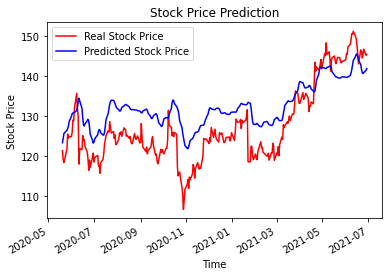

In [35]:
vector = np.vectorize(np.float)
t_pred = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], ))
acc_val = vector(df.loc[(split_size+120):, 'close'].values)
time = df.loc[(split_size+120):, 'time'].values
plt.plot(time,acc_val, color = 'red', label = 'Real Stock Price')
plt.plot(time,t_pred, color = 'blue', label = 'Predicted Stock Price')
plt.gcf().autofmt_xdate()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(acc_val,predicted_stock_price)

6.251328942435128